<a href="https://colab.research.google.com/github/bsjin1122/deep-learning/blob/main/03_keras/gradient_tape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 자동 미분

In [1]:
# 5개의 값을 포함하는 a, b 텐서를 생성한다.
# a,b가 훈련 가능한 텐서인지 확인 -> 훈련 가능한 텐서에 대해서만 그래디언트 계산 가능.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# a, b의 Variable 를 생성
a = tf.Variable([1, 2, 3, 4, 5], dtype=tf.float32)
b = tf.Variable([10, 20, 30, 40, 50], dtype=tf.float32)

# 미분 계산을 위해서 a, b가 미분 가능한 객체인지 확인
print(f'a.trainable: {a.trainable}\nb.trainable: {b.trainable}')


a.trainable: True
b.trainable: True


In [2]:
# c = a * b
# c를 a 대한 편미분 => b
# c를 b 대한 편미분 => a
with tf.GradientTape() as tape: #범위를 정의하고 tape로 지정한다.
    c = a * b
grads = tape.gradient(c, [a, b]) #tape: 계산 그래프를 저장, with문 밖에서 tape.gradient()로 미분 계산, 편미분을 각각 구하여 반환
tf.print(f'dc/da: {grads[0]}')
tf.print(f'dc/db: {grads[1]}')

dc/da: [10. 20. 30. 40. 50.]
dc/db: [1. 2. 3. 4. 5.]


In [3]:
# 손실을 구한 뒤, 자동 미분 기능을 활용하여 w, b의 값을 업데이트하여 최종 w, b 값을 찾도록 한다.
# x, y 샘플 데이터셋을 생성
x = tf.Variable(np.random.normal(size=(100, )), dtype=tf.float32)
y = 2*x + 3
print(f'x[:5]: {x[:5].numpy()}\ny[:5]: {y[:5].numpy()}')

x[:5]: [-0.5336969  -0.91483474  1.0948709   0.5287162   0.83741397]
y[:5]: [1.9326062 1.1703305 5.189742  4.057432  4.674828 ]


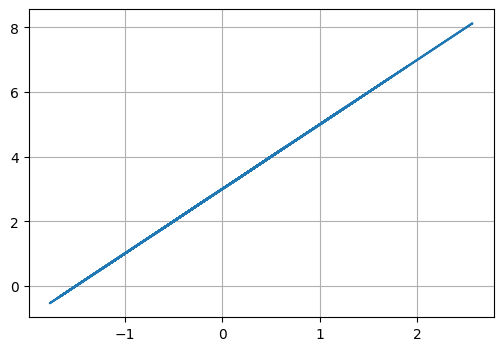

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x.numpy(), y.numpy())
ax.grid()
plt.show()

In [5]:
# 학습률, 최대 Epoch 정의
learning_rate = 0.25
EPOCHS = 100

# w, b 초기값을 0.0으로 설정. float 타입을 가져야 한다.
w = tf.Variable(0.0)
b = tf.Variable(0.0)

for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:
        # y_hat(예측 값)
        y_hat = w*x + b
        # 손실 계산(MSE)
        loss = tf.reduce_mean((y_hat - y)**2)

    # 그라디언트 계산
    dw, db = tape.gradient(loss, [w, b])

    # 그라이언트 업데이트
    w = tf.Variable(w - learning_rate * dw)
    b = tf.Variable(b - learning_rate * db)

    print(f'epoch: {epoch}, loss: {loss.numpy():.4f}, w: {w.numpy():.4f}, b: {b.numpy():.4f}')

    # Error가 0.0005보다 작으면 루프 종료
    if loss.numpy() < 0.0005:
        break

epoch: 0, loss: 12.6411, w: 0.8853, b: 1.5166
epoch: 1, loss: 3.3244, w: 1.3772, b: 2.2676
epoch: 2, loss: 0.8853, w: 1.6512, b: 2.6390
epoch: 3, loss: 0.2392, w: 1.8043, b: 2.8224
epoch: 4, loss: 0.0657, w: 1.8899, b: 2.9128
epoch: 5, loss: 0.0183, w: 1.9380, b: 2.9573
epoch: 6, loss: 0.0052, w: 1.9650, b: 2.9792
epoch: 7, loss: 0.0015, w: 1.9802, b: 2.9899
epoch: 8, loss: 0.0004, w: 1.9888, b: 2.9951


## 자동 미분을 활용한 모델 훈련

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 케라스의 내장 데이터셋에서 mnist 데이터셋을 로드
mnist = tf.keras.datasets.mnist

# load_data()로 데이터셋을 로드 합니다.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 정규화
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

11490434/11490434 [==============================] - 0s 0us/step


In [8]:
# 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

# 손실함수 정의
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# 옵티마이저 정의
optimizer = tf.keras.optimizers.Adam()

In [9]:
# 기록을 위한 Metric 정의
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [10]:
# 배치 생성 함수
def get_batches(x, y, batch_size=32):
    for i in range(int(x.shape[0] // batch_size)):
        x_batch = x[i * batch_size: (i + 1) * batch_size]
        y_batch = y[i * batch_size: (i + 1) * batch_size]
        yield (np.asarray(x_batch), np.asarray(y_batch))

In [11]:
@tf.function
def train_step(images, labels):
    # GradientTape 적용
    with tf.GradientTape() as tape:
        # 예측
        prediction = model(images, training=True)
        # 손실
        loss = loss_function(labels, prediction)
    # 미분 (gradient) 값 계산
    gradients = tape.gradient(loss, model.trainable_variables)
    # optimizer 적용
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # loss, accuracy 계산
    train_loss(loss)
    train_accuracy(labels, prediction)

@tf.function
def valid_step(images, labels):
    # 예측
    prediction = model(images, training=False)
    # 손실
    loss = loss_function(labels, prediction)

    # loss, accuracy 계산
    valid_loss(loss)
    valid_accuracy(labels, prediction)

In [12]:
# 초기화 코드
train_loss.reset_states()
train_accuracy.reset_states()
valid_loss.reset_states()
valid_accuracy.reset_states()

# Epoch 반복
for epoch in range(5):
    # batch 별 순회
    for images, labels in get_batches(x_train, y_train):
        # train_step
        train_step(images, labels)

    for images, labels in get_batches(x_test, y_test):
        # valid_step
        valid_step(images, labels)

    # 결과 출력
    metric_template = 'epoch: {}, loss: {:.4f}, acc: {:.2f}%, val_loss: {:.4f}, val_acc: {:.2f}%'
    print(metric_template.format(epoch+1, train_loss.result(), train_accuracy.result()*100,
                                 valid_loss.result(), valid_accuracy.result()*100))

epoch: 1, loss: 0.2386, acc: 92.91%, val_loss: 0.1455, val_acc: 95.18%
epoch: 2, loss: 0.1700, acc: 94.91%, val_loss: 0.1269, val_acc: 95.96%
epoch: 3, loss: 0.1354, acc: 95.92%, val_loss: 0.1224, val_acc: 96.22%
epoch: 4, loss: 0.1144, acc: 96.54%, val_loss: 0.1278, val_acc: 96.18%
epoch: 5, loss: 0.0991, acc: 97.00%, val_loss: 0.1317, val_acc: 96.18%
